# NF intro, inspired by SIREN 

Made for Jakob Sauer, to demystify neural fields.

Author: vand@dtu.dk, 2025


In [5]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import skimage

## Neural field is a neural network.

The cell below dictates the architecture of the neural field. This is terribly important for the good performance, but not at all important for the understanding of the concept. So we just move on.

In [6]:
class SineLayer(nn.Module):
    # See paper sec. 3.2, final paragraph, and supplement Sec. 1.5 for discussion of omega.
    # If is_first=True, omega is a frequency factor which multiplies the activations before the
    # nonlinearity. Different signals may require different omega in the first layer - this is a
    # hyperparameter.
    # If is_first=False, then the weights will be divided by omega to keep the magnitude of
    # activations constant, but boost gradients to the weight matrix (see supplement Sec. 1.5)

    def __init__(self, indim, outdim, bias=True, is_first=False, omega=30):
        super().__init__()
        self.omega = omega
        self.linear = nn.Linear(indim, outdim, bias=bias)
        with torch.no_grad():
            w = 1 / indim if is_first else (6 / indim)**0.5 / omega
            self.linear.weight.uniform_(-w, w)
    def forward(self, input):
        return torch.sin(self.omega * self.linear(input))  # Here is sine activation


class Siren(nn.Module):
    def __init__(self, indim=2, outdim=1, nr_hidden=3, hiddendim=256,
                 first_omega=30, hidden_omega=30):
        super().__init__()
        layers = []
        layers.append(SineLayer(indim, hiddendim, is_first=True, omega=first_omega))
        for i in range(nr_hidden):
            layers.append(SineLayer(indim=hiddendim, outdim=hiddendim,
                                      is_first=False, omega=hidden_omega))
        final_linear = nn.Linear(hiddendim, outdim)
        with torch.no_grad():
            w = (6 / hiddendim)**0.5 / hidden_omega
            final_linear.weight.uniform_(-w, w)
        layers.append(final_linear)
        self.net = nn.Sequential(*layers)


    def forward(self, coords):
        output = self.net(coords)
        return output

## Investigate the model

First, initialize a model.

In [7]:
model = Siren()

Let's look at the parameters of the model. Those are the weights and biases, which will be updated during training. 

One is usually *not* looking at weights, but on the output of the network. So this is just to get a feeling of the model.

In [ ]:
params_shapes = []
params_total_number = 0
for param in model.parameters():
    params_shapes.append(tuple(param.shape))
    params_total_number += param.numel()
print(f"Shapes of parameters: {params_shapes}")
print(f"Total number of parameters: {params_total_number}")

for param in model.parameters():
    print(f"{param}")

Shapes of parameters: [(256, 2), (256,), (256, 256), (256,), (256, 256), (256,), (256, 256), (256,), (1, 256), (1,)]
Total number of parameters: 198401
Parameter containing:
tensor([[ 0.0729,  0.2813],
        [ 0.0138, -0.2727],
        [ 0.1151, -0.4124],
        [-0.3452, -0.1273],
        [-0.4290, -0.4671],
        [-0.3647, -0.2444],
        [ 0.3335,  0.2430],
        [-0.4114, -0.0219],
        [-0.4829,  0.0969],
        [-0.4367,  0.4213],
        [-0.3045, -0.2671],
        [ 0.0320,  0.2892],
        [ 0.2812,  0.0803],
        [-0.2850, -0.1080],
        [-0.4739, -0.0971],
        [-0.4996, -0.3096],
        [ 0.0444, -0.3178],
        [ 0.2369,  0.0305],
        [-0.2847,  0.0517],
        [ 0.3353, -0.2492],
        [-0.3209, -0.0573],
        [-0.1137, -0.1638],
        [ 0.0113,  0.2909],
        [-0.2156, -0.4756],
        [-0.2810, -0.4160],
        [-0.1214,  0.4036],
        [-0.0548, -0.0098],
        [-0.0707, -0.1762],
        [ 0.2851, -0.4095],
        [-0.45

Let's also look at gradients, even though nothing has been done yet.

In [9]:
for param in model.parameters():
    print(f"{param.grad}")

None
None
None
None
None
None
None
None
None
None


Let's see the prediction the network gives before any training. I sample image grid in different resolutions, and plot the predictions. I write this as functions, as I will need to do this many times.

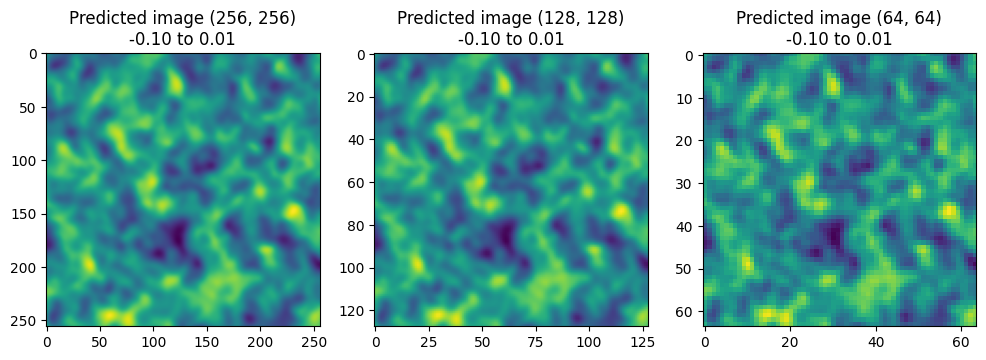

In [ ]:
def image_coordinates(size):
    '''Helping function giving the normalized coordinates of the pixels in the 
    image as a torch tensor.'''
    r, c = size
    x, y = torch.linspace(-1, 1, r), torch.linspace(-1, 1, c)
    X, Y = torch.meshgrid(x, y, indexing='ij')  
    coords = torch.stack([X.flatten(), Y.flatten()], dim=1)  
    return coords

def show_predictions(model):

    sizes = [(256, 256), (128, 128), (64, 64)]
    fig, ax = plt.subplots(1, len(sizes), figsize=(12, 4))

    with torch.no_grad():  # I say to torch that I will not ask it to optimize anything based on the computation in this block
        for size, a in zip(sizes, ax):
            coords = image_coordinates(size)
            pred = model(coords).reshape(size)
            a.imshow(pred.detach())
            a.set_title(f'Predicted image {size}\n{pred.min():.2f} to {pred.max():.2f}')
        plt.show()
        
show_predictions(model)

## The first update

Now, I make a gray image with a white frame in the middle, and a black background. I will use this as a target image, i.e. I will formulate the loss as the difference between this image and the prediction of the network.

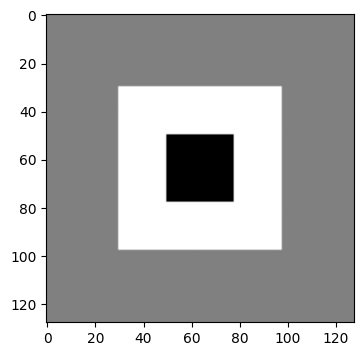

In [ ]:
target = torch.zeros(128, 128)
target[30:-30, 30:-30] = 1.0
target[50:-50, 50:-50] = -1

fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.imshow(target.detach(), vmin=-1, vmax=1, cmap='gray')
plt.show()

Notice that in the code below, I did not say no_grad().

The squeeze and flatten operations are needed to get the prediction and the image in the same shape from (N*N, 1) and (N, N).

In [ ]:
# Notice I did not say no_grad() here!
coords = image_coordinates(target.shape)
pred = model(coords)  # Forward pass
diff = pred.squeeze() - target.flatten()
loss = diff.pow(2).mean()  # Loss needs to be a scalar

for param in model.parameters():
    print(f"{param.grad}", end=' ')

None None None None None None None None None None 

In [ ]:
loss.backward()  # This gets gradients to be computed
for param in model.parameters():
    print(f"{param.grad}", end=' ')

tensor([[-8.5462e-05,  1.7305e-03],
        [-2.0887e-03,  4.3723e-04],
        [-1.2666e-05,  1.0565e-03],
        [-1.9107e-03, -9.7916e-04],
        [-1.2141e-03, -1.2041e-03],
        [ 4.2278e-04, -2.4683e-05],
        [-9.1190e-04, -1.7993e-04],
        [ 8.9993e-04, -2.9021e-03],
        [ 1.0760e-03,  1.2038e-03],
        [-5.2851e-06,  1.2757e-03],
        [ 2.4228e-03, -2.6150e-03],
        [ 2.1533e-04,  2.2551e-03],
        [-1.0465e-03, -7.5350e-04],
        [-7.2971e-04, -1.2839e-03],
        [-2.1356e-03,  1.1562e-03],
        [-7.8541e-04,  7.2563e-04],
        [ 1.3913e-03, -6.6558e-04],
        [-8.8990e-04, -2.4550e-03],
        [ 2.3147e-04, -1.1634e-03],
        [-4.7347e-04, -9.6157e-04],
        [-1.5895e-03, -1.2503e-03],
        [ 1.6996e-03,  3.8710e-04],
        [ 3.4622e-04, -9.1111e-04],
        [-8.2120e-05,  7.9979e-05],
        [-2.3765e-03, -2.9355e-04],
        [-1.8210e-03,  1.2682e-03],
        [-3.7856e-03, -1.4249e-03],
        [-3.9512e-04, -6.833

In [14]:
learning_rate = 1

for param in model.parameters():
    param.data -= learning_rate * param.grad

model.zero_grad()  # This clears the gradients

for param in model.parameters():
    print(f"{param.grad}")

tensor([[0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0

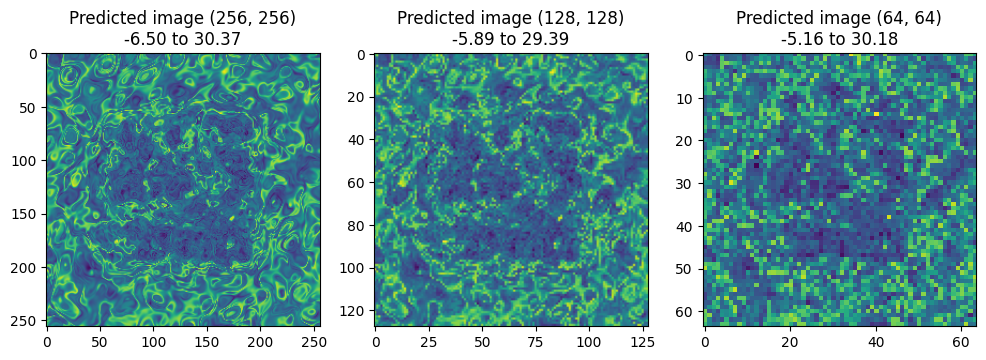

In [15]:
show_predictions(model)

## First training

Now, I want to train the model to predict black on the one side of the image, and white on the other. I draw random points from the image, and pass a batch of points to the model.

Iteration 0, Loss: 129.20465087890625


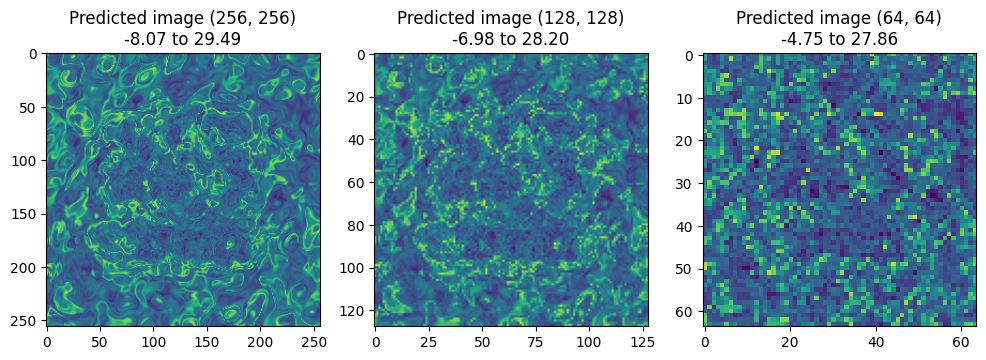

Iteration 50, Loss: 3.208742618560791


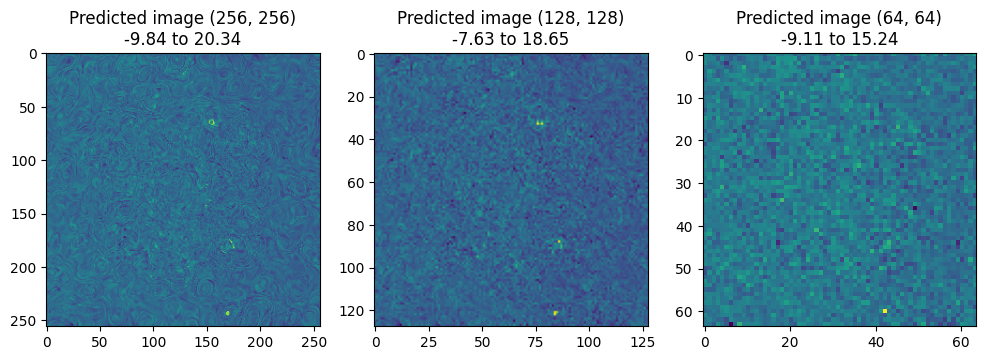

Iteration 100, Loss: 1.6461645364761353


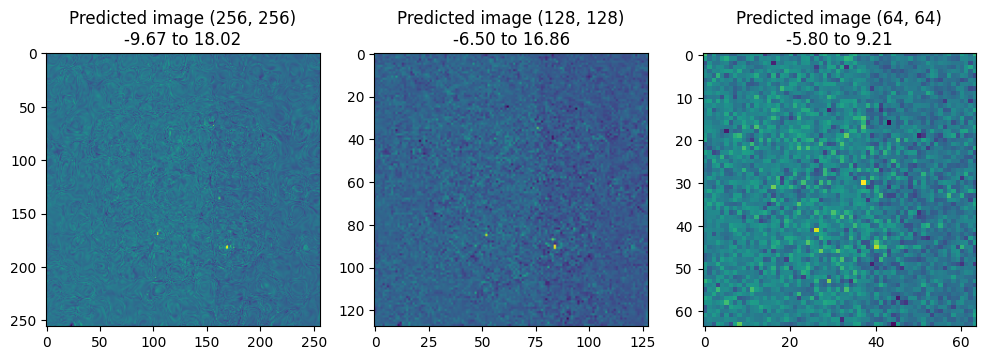

Iteration 150, Loss: 1.2044910192489624


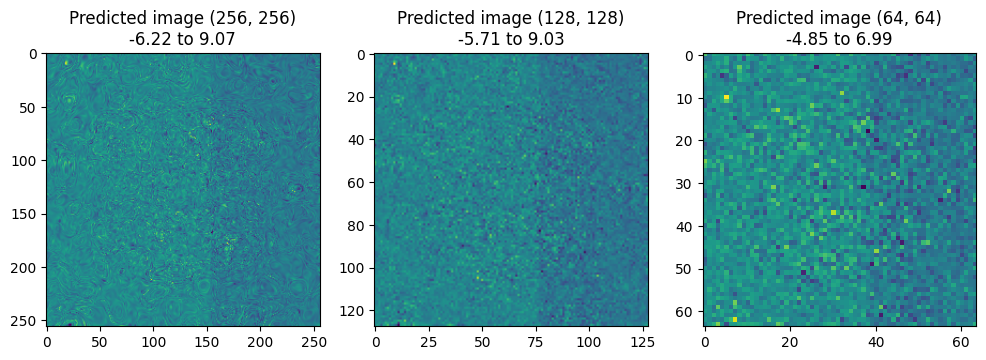

Iteration 200, Loss: 1.044844388961792


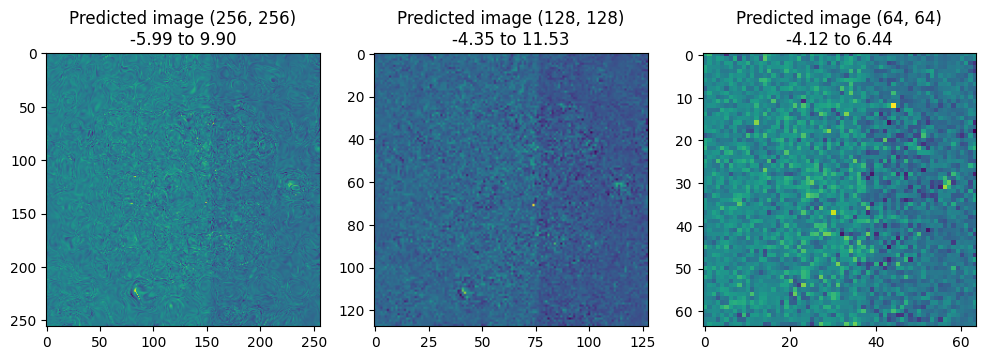

Iteration 250, Loss: 0.7832478284835815


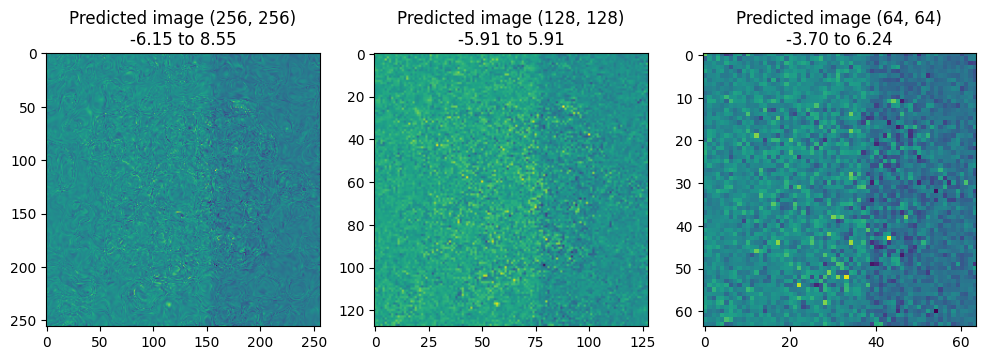

Iteration 300, Loss: 0.6126593947410583


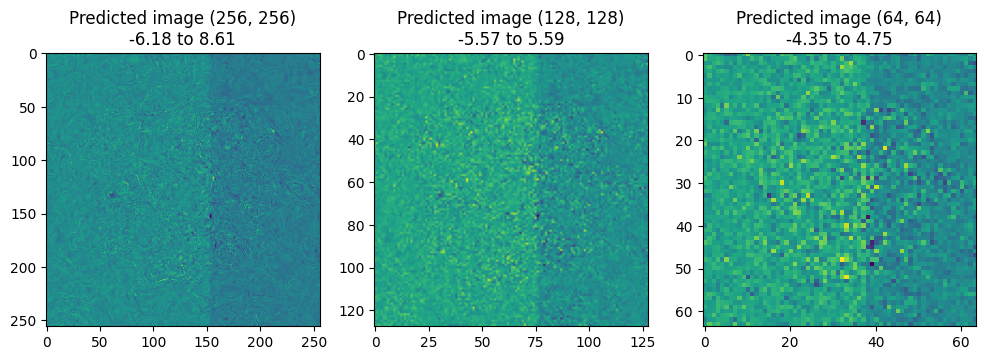

Iteration 350, Loss: 0.5369186401367188


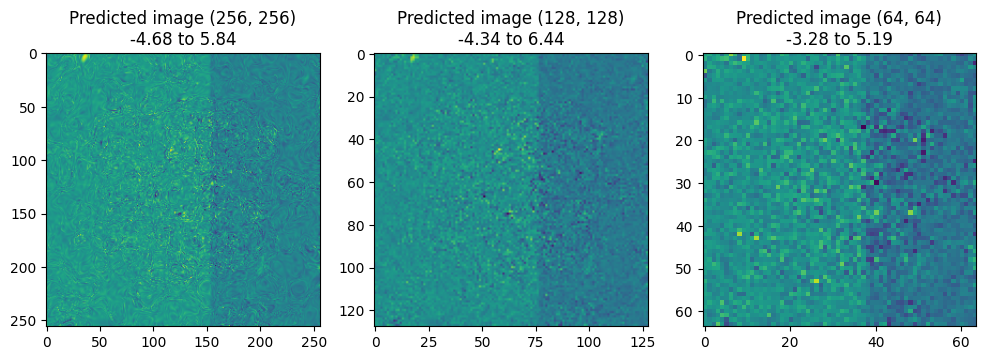

Iteration 400, Loss: 0.47740620374679565


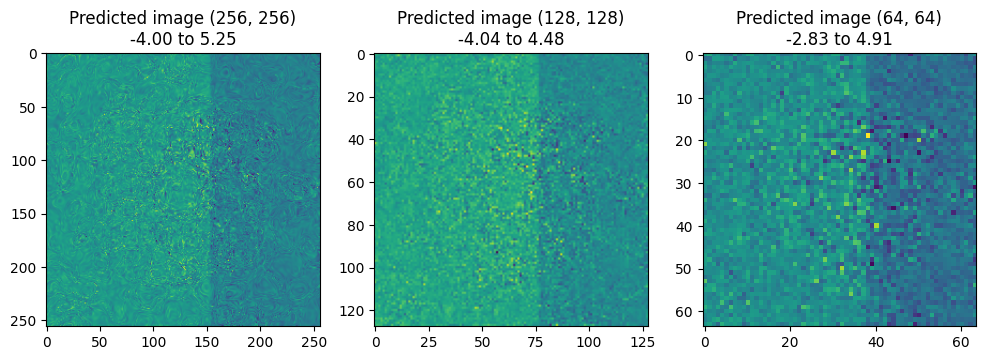

Iteration 450, Loss: 0.31659579277038574


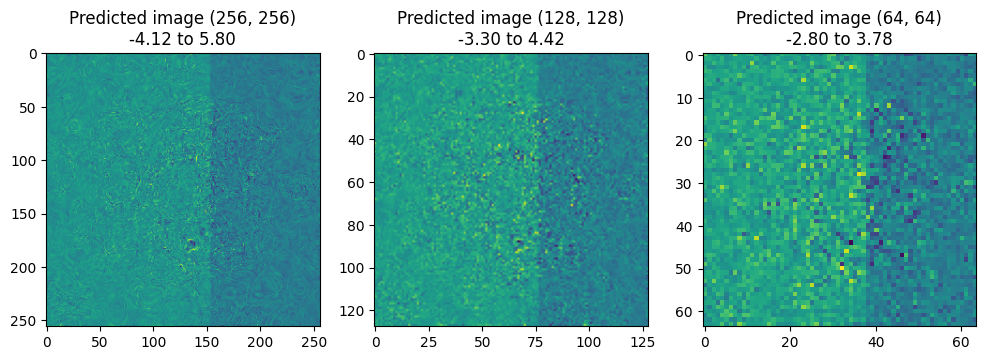

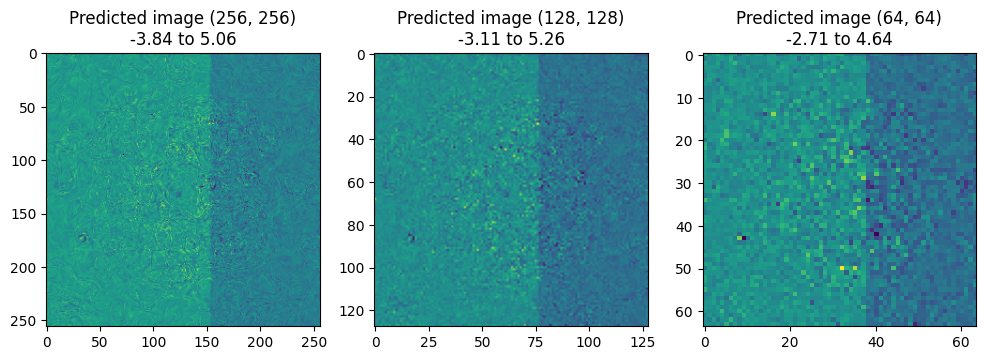

In [16]:

iters = 500
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
batch_size = 1000

for i in range(iters):
    coords = torch.rand((batch_size, 2)) * 2 - 1  # Random coordinates in [-1, 1]
    gt = (coords[:, 1] < 0.2).float()  # This is what I will use as a target: zeros and ones
    pred = model(coords).squeeze()  # This is what the model predicts
    loss = (gt - pred).pow(2).mean()  # This is my loss: sum of squares
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if i % (iters//10) == 0:
        print(f"Iteration {i}, Loss: {loss.item()}")
        show_predictions(model)

show_predictions(model)


## A more realistic example

Finally, let's train the model to predict an image.

In [17]:
image = skimage.data.camera()
image = skimage.transform.rescale(image, 0.25, anti_aliasing=False)
image = image.astype(float)
print(image.shape, image.min(), image.max())

coords = image_coordinates(image.shape)
values = torch.tensor(image).flatten()


(128, 128) 0.00980392156862745 1.0


Iteration 0, Loss: 0.4283880855725335


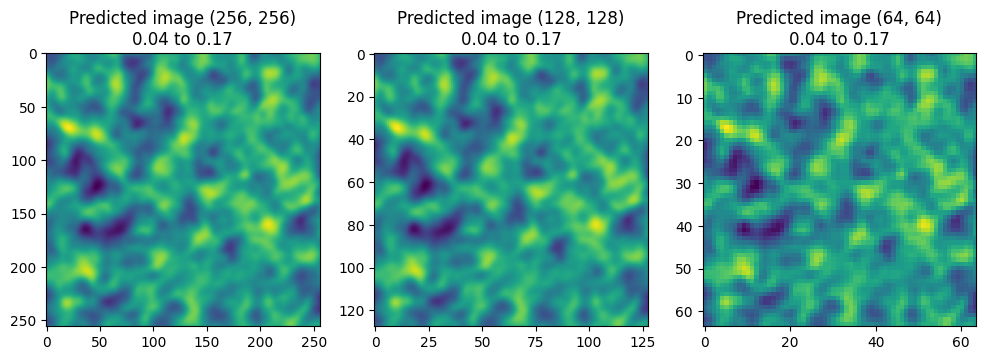

Iteration 10, Loss: 0.05158686537533763


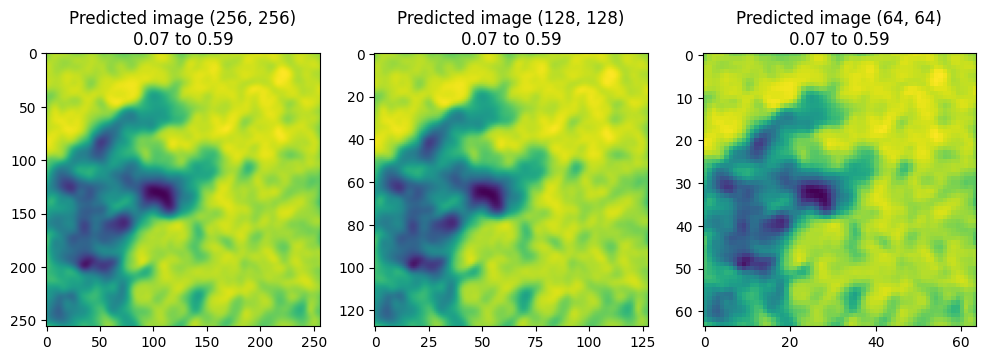

Iteration 20, Loss: 0.01410257617953085


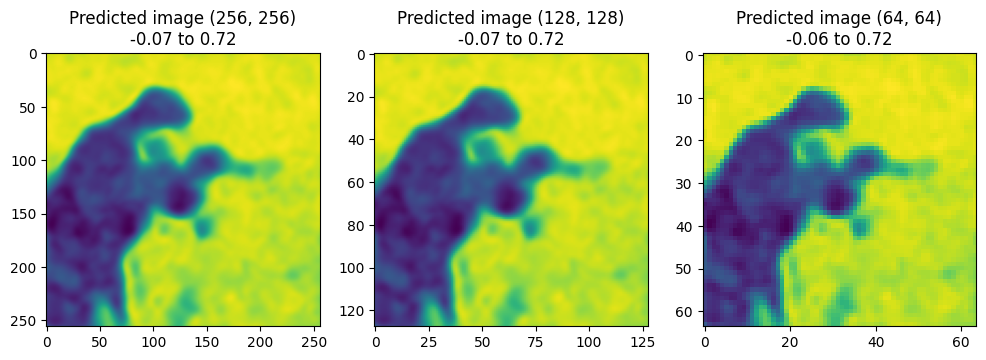

Iteration 30, Loss: 0.0075528105770511465


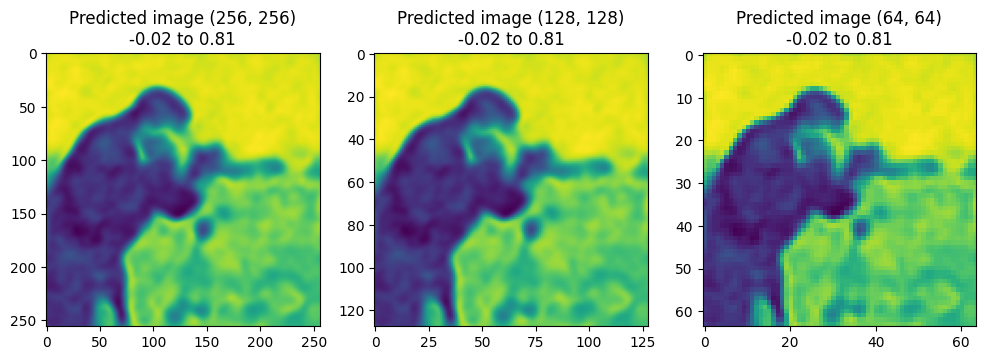

Iteration 40, Loss: 0.005782184683963556


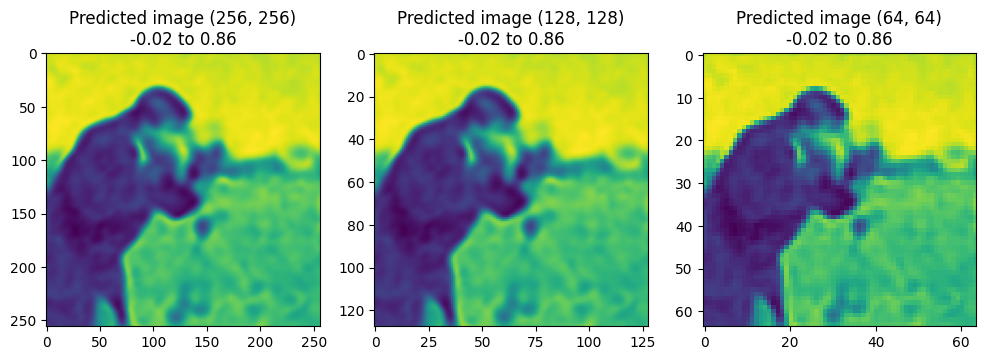

Iteration 50, Loss: 0.005039182761149862


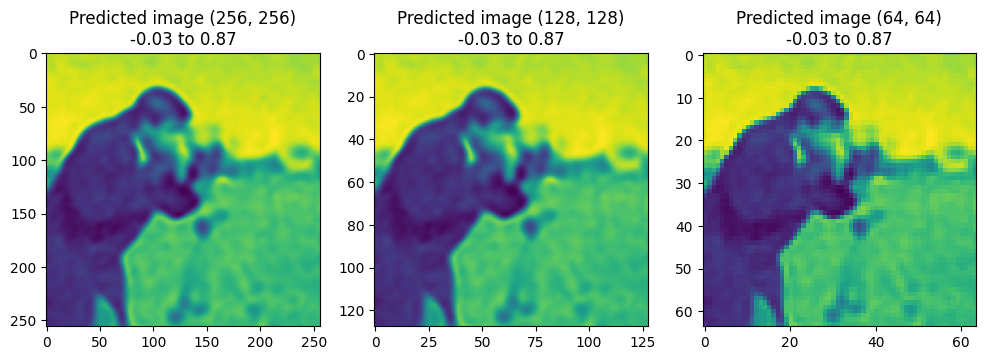

Iteration 60, Loss: 0.004608940447896632


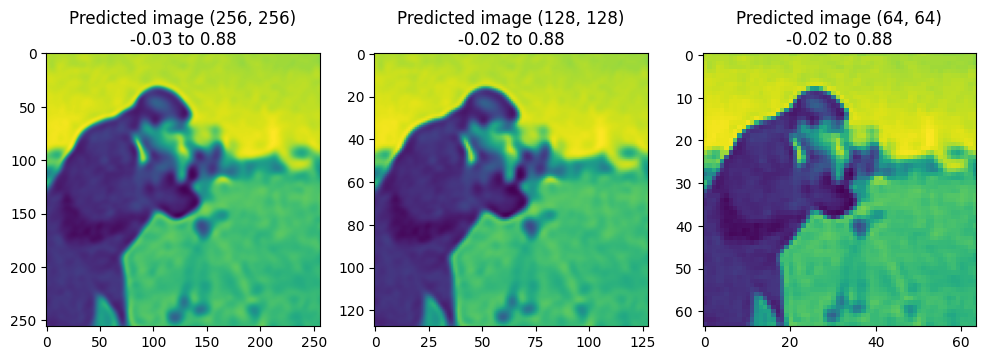

Iteration 70, Loss: 0.004310487241985959


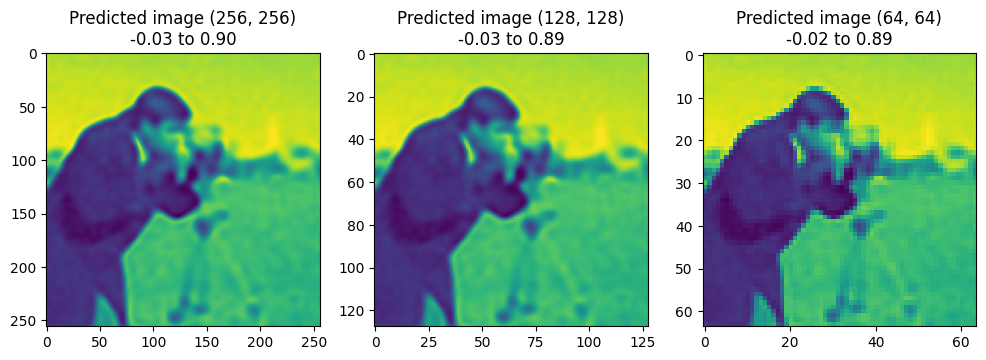

Iteration 80, Loss: 0.004089069251185347


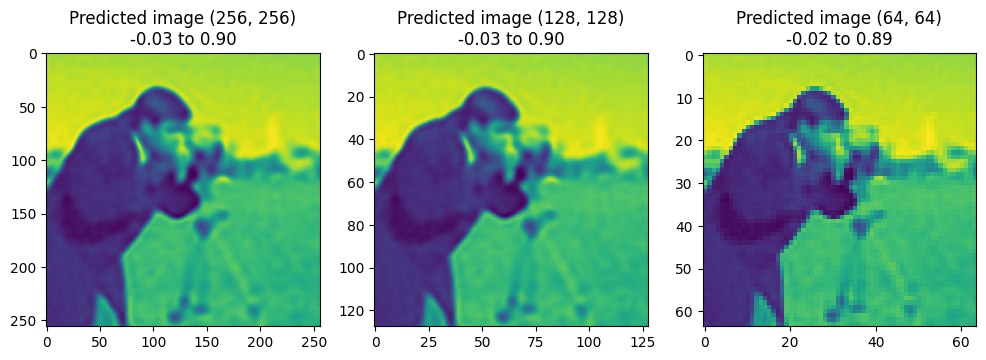

Iteration 90, Loss: 0.0039061245930932928


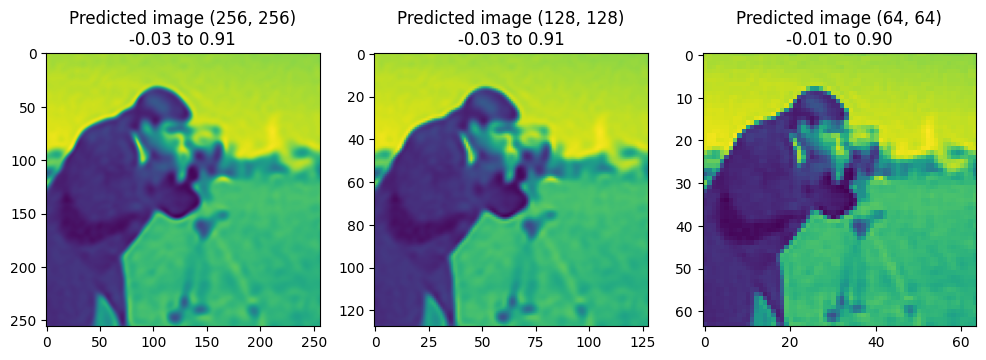

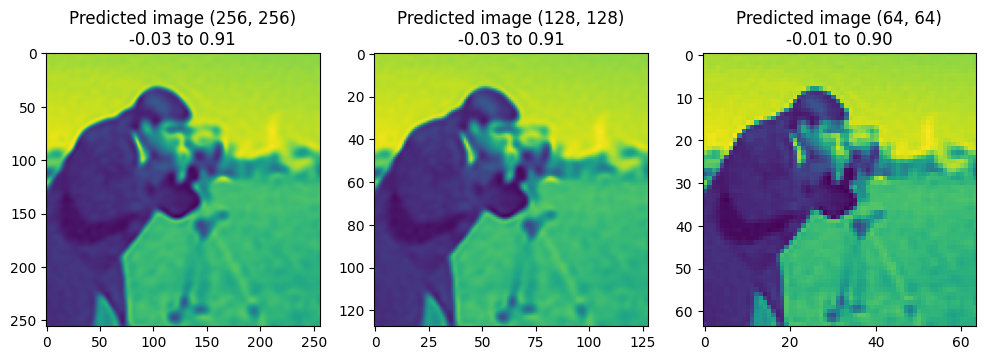

In [19]:
model = Siren()  ## I start with a new model

iters = 100
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

for i in range(iters):
    pred = model(coords).squeeze()  # This is what the model predicts
    loss = (values - pred).pow(2).mean()  # This is my loss: sum of squares
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if i % (iters//10) == 0:
        print(f"Iteration {i}, Loss: {loss.item()}")
        show_predictions(model)

show_predictions(model)
